In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import json
import os
import tweepy
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
%matplotlib inline

## Data Gathering

Read twitter_archive_enchanced.csv in pandas

In [2]:
enhanced_archive = pd.read_csv('twitter-archive-enhanced.csv')

Get image_predictioniction.tsv file from internet using requests library


In [3]:
#image predictions data url
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

#write the response content to a file to read later in pandas
response = requests.get(url)
with open(url.split('/')[-1], mode = 'wb') as file:
    file.write(response.content)

In [4]:
image_prediction = pd.read_csv('image-predictions.tsv', sep ='\t')

Get tweets retweet count and favorite("like") count from  Twitter API using tweepy library

In [5]:
api_key = '######'
secret_key = '######'
access_token = '#######'

#authenticate and get Twitter API access
auth = tweepy.OAuth2AppHandler(
api_key,secret_key)

api = tweepy.API(auth,wait_on_rate_limit= True)


Retrieve each tweets JSON data and save them in tweet_json.txt file

In [ ]:
"""
source code url: https://video.udacity-data.com/topher/2018/November/5be5fb4c_twitter-api/twitter-api.py
"""
tweet_ids = enhanced_archive.tweet_id
print("Number of Tweet IDs {}".format(len(tweet_ids)))

#to determine the progress of saved files
count = 0
#Store the ids with failed query in a dict
fails_dict = {}
start_timer = timer()

#Save each JSON data into tweet_json.txt file
with open('tweet_json.txt', 'w') as outfile:
    for tweet_id in tweet_ids:
        count += 1
        print('{a} : {b}'.format(a = count, b = tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode = 'extended')
            json_string = tweet._json
            json.dump(json_string, outfile)
            outfile.write('\n')
            print('Success')
        except tweepy.TweepyException as error:
            print('failed')
            fails_dict[tweet_id] = error
            pass
end_timer = timer()

print(end_timer - start_timer)
print(fails_dict)

In [7]:
#load each line into a json format
df_list = []
data = [json.loads(line) for line in open ('tweet-json.txt','r')]

In [8]:
#retrieve tweet_id, retweet_count and favorite_count from each json object
for json in data:
    tweet_id = json['id']
    retweet_count = json['retweet_count']
    favorite_count = json['favorite_count']
    df_list.append(
        {
            'tweet_id':tweet_id,
            'retweet_count':retweet_count,
            'favorite_count':favorite_count
        }
    ) 

Load tweets data with retweet count and favorite count into pandas

In [ ]:
additional_tweet = pd.DataFrame(df_list)

## Assessing

In [ ]:
enhanced_archive

In [ ]:
image_prediction

In [ ]:
additional_tweet

In [ ]:
enhanced_archive.info()

In [ ]:
enhanced_archive.describe()

In [ ]:
sum(enhanced_archive.in_reply_to_status_id.isnull())

In [ ]:
sum(enhanced_archive.in_reply_to_user_id.isnull())

In [ ]:
sum(enhanced_archive.tweet_id.duplicated())

In [ ]:
enhanced_archive['name'].unique()

In [ ]:
enhanced_archive['source']

In [ ]:
enhanced_archive[enhanced_archive.name.str.islower()].name.unique()

In [ ]:
enhanced_archive.text[979]

In [ ]:
sum(enhanced_archive.retweeted_status_id.isnull())

In [ ]:
image_prediction.info()

In [ ]:
image_prediction.sample(5)

#### Quality
##### `enhanced_archive` table

- Erorrneous datatypes (timestamp, retweeted_status_timestamp, doggo, floofer, pupper, puppo)
- None values in doggo, floofwe, pupper , puppo columns are objects instead of NaN values
- Names of some dogs are 'a', 'such', 'the', 'life', 'officialy', etc.
- timestamp has additional +0000 at the end
- source column has `<a href=` in the start and `r...` in the end
- name column as None in place of NaN values

#### `image_prediction` table
- Incomplete data as compared to 2356 counts in enchanced_archive and addtional_tweet data.

#### `All tables`
- tweet_id is an int data type instead of object

### Tidiness
#### `enhanced_archive` table
- `additional_tweet` table should be part of enhanced_archive table

#### `image_prediction` table
- p1,p2,p3 has some names with lower case
- Change p1,p1_conf,p2,p2_conf,p3,p3_conf, jpg_url to a more descriptive column names

## Cleaning

In [ ]:
enhanced_archive_copy = enhanced_archive.copy()
image_prediction_copy = image_prediction.copy()
additional_tweet_copy = additional_tweet.copy()

#### `enchanced_archive`:  Extract a valid timestamp from timestamp column and retweeted_status_timestamp column and change their datatype to pandas datetime

In [ ]:
enhanced_archive_copy.timestamp = pd.to_datetime(enhanced_archive_copy.timestamp.str[:-len('+0000')])

In [ ]:
enhanced_archive_copy.timestamp

In [ ]:
enhanced_archive_copy.retweeted_status_timestamp = pd.to_datetime(enhanced_archive_copy.retweeted_status_timestamp.str[:-len('+0000')])

In [ ]:
enhanced_archive_copy.retweeted_status_timestamp

Change the dtypes of doggo,floofer,pupper,puppo to category

In [ ]:
enhanced_archive_copy[['doggo','floofer','pupper','puppo']] = enhanced_archive_copy[['doggo','floofer','pupper','puppo']].astype('category')

In [ ]:
enhanced_archive_copy[['doggo','floofer','pupper','puppo']].info()

Check if `retweeted_status_timestamp` column in `enhanced_archive` table has a non-null value

In [ ]:
sum(~enhanced_archive_copy.retweeted_status_timestamp.isnull())

`enhanced archive`: Change the None values in doggo, floofer, pupper and puppo columns in to pandas NaN values 

In [ ]:
enhanced_archive_copy[['doggo','floofer','pupper','puppo']] = (enhanced_archive_copy[['doggo','floofer','pupper','puppo']]
                                                               .replace(to_replace= ['None'], value=np.nan))

In [ ]:
enhanced_archive_copy[['doggo','floofer','pupper','puppo']].info()

In [ ]:
enhanced_archive_copy.doggo.unique()

In [ ]:
enhanced_archive_copy.floofer.unique()

`enchanced archive`: Remove `<a href` from start of source and `r...` from end of source column values

In [ ]:
enhanced_archive_copy.source.unique()

In [ ]:
'''
url regex source code : https://uibakery.io/regex-library/url-regex-python
'''
enhanced_archive_copy.source = (enhanced_archive_copy.source.str
                                .extract("(https?:\\/\\/(?:www\\.)?[-a-zA-Z0-9@:%._\\+~#=]{1,256}\\.[a-zA-Z0-9()]{1,6}\\b(?:[-a-zA-Z0-9()@:%_\\+.~#?&\\/=]*))"))

In [ ]:
enhanced_archive_copy.source

`enhanced archive`: Replace invalid dog names like 'a','the', and None values etc with NaN values

In [ ]:
invalid_names = enhanced_archive[enhanced_archive.name.str.islower()].name.unique()

A function to replace invalid names with NaN values in enhanced_archive

In [ ]:
def fix_name(a):
    if a in invalid_names or a == 'None':
        a = np.NaN
    return a

In [ ]:
enhanced_archive_copy.name = enhanced_archive_copy.name.apply(fix_name)

In [ ]:
enhanced_archive_copy.name[enhanced_archive_copy.name.values == 'None']

In [ ]:
enhanced_archive_copy.name[enhanced_archive_copy.name.values =='a']

Change the datatype of tweet_id to object in `all dataframes` as it is an identification number and does not need to be int for computations

In [ ]:
additional_tweet_copy.tweet_id = additional_tweet_copy.tweet_id.astype('str')
image_prediction_copy.tweet_id = image_prediction_copy.tweet_id.astype('str')
enhanced_archive_copy.tweet_id = enhanced_archive_copy.tweet_id.astype('str')

In [ ]:
additional_tweet_copy.tweet_id

In [ ]:
enhanced_archive_copy.tweet_id

Merge `addtional_tweet`into `enhanced_archive` table

In [ ]:
enhanced_archive_copy = enhanced_archive_copy.merge(additional_tweet_copy,how = 'left', on ='tweet_id')

Retrieve data from `enchanced_archive` data to match the available data in `image_prediction` table 

In [ ]:
#get the tweet ids from image_prediction table
image_prediction_tweet_ids = image_prediction_copy.tweet_id.values

#query enhanced_archive table to retrieve tweet ids available in image_predictioniction table
enhanced_archive_tweet_ids = enhanced_archive_copy.tweet_id.values

available_tweet_ids = []
for tweet_id in image_prediction_tweet_ids:
    if tweet_id in enhanced_archive_tweet_ids:
        available_tweet_ids.append(tweet_id)
        

enhanced_archive_copy = enhanced_archive_copy[enhanced_archive_copy.tweet_id.isin(image_prediction_tweet_ids)]

In [ ]:
enhanced_archive_copy.head()

In [ ]:
enhanced_archive_copy.shape

In [ ]:
image_prediction_copy.info()

Normalize values in p1,p2,p3 in `image_prediction` table by capitalizing values with small first letters

In [ ]:
image_prediction_copy[['p1','p2','p3']] = image_prediction_copy[['p1','p2','p3']].apply(lambda x: x.str.capitalize())

In [ ]:
image_prediction_copy

Change all p's in p1, p2, p3, p1_conf,p2_conf,p3_conf to prediction and jpg_url to image_url

In [ ]:
image_prediction_columns = image_prediction_copy.columns
new_image_prediction_columns = [p.replace('p','prediction_') for p 
                          in image_prediction_columns[3:]]
image_prediction_copy.set_axis(list(image_prediction_columns[:3])+
                               list(new_image_prediction_columns), axis='columns',inplace=True)
image_prediction_copy.rename(columns={
    'jpg_url':'image_url'
},inplace=True)

In [ ]:
image_prediction_copy

### Assessing

#### Quality
- prediction_1 has the highest prediction confidence as compared to p2 and p3
- merge prediction_1 from `image_prediction` into enhanced_archive table


#### Tidiness
- rename p1 column to dog_breed in `image_prediction` table

### Cleaning


Keep tweet_id, image_url and prediction_1 column in `image_prediction` table and drop the rest

In [ ]:
columns_to_keep = ['tweet_id','image_url','prediction_1']
image_prediction_copy = image_prediction_copy[columns_to_keep]

In [ ]:
image_prediction_copy

Rename prediction_1 column in `image_prediction` table to dog_breed

In [ ]:
image_prediction_copy.rename(columns={
    'prediction_1':'dog_breed'
}, inplace=True)

In [ ]:
image_prediction_copy

Merge `image_prediction` table into `enhanced_archive`

In [ ]:
enhanced_archive_copy = enhanced_archive_copy.merge(image_prediction_copy, how='left',on='tweet_id')

In [ ]:
enhanced_archive_copy

## Storing Data

Save wrangled dataframe into csv

In [9]:
enhanced_archive_copy.to_csv('twitter_archive_master.csv',index = False)

NameError: name 'enhanced_archive_copy' is not defined

## Analysis and Visualization

### Insights
<ul>
    <li><a href=#eda1>1. Which dog breed has the highest retweets and like? </a></li>
    <li><a href=#eda2> 2.  Which dog names are the top 10 most common? </a></li>
    <li><a href=#eda3> 3. Did likes and retweets from #WeRateDogs decrease or increase overtime? </a></li>
</ul>

Read the `twitter_archive_master.csv`(wrangled data) in to pandas for analysis

In [10]:
import datetime
df = pd.read_csv('twitter_archive_master.csv',parse_dates=['timestamp'])

In [11]:
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,image_url,dog_breed
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,http://twitter.com/download/iphone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,10,Phineas,NaN,NaN,NaN,NaN,8853.0,39467.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,Orange
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,http://twitter.com/download/iphone,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,10,Tilly,NaN,NaN,NaN,NaN,6514.0,33819.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,http://twitter.com/download/iphone,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,10,Archie,NaN,NaN,NaN,NaN,4328.0,25461.0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,http://twitter.com/download/iphone,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,10,Darla,NaN,NaN,NaN,NaN,8964.0,42908.0,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Paper_towel
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,http://twitter.com/download/iphone,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,10,Franklin,NaN,NaN,NaN,NaN,9774.0,41048.0,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,Basset


<a id = 'eda1'> </a>
### 1. Which dog breed has the highest level of retweets and likes ?

In [12]:
#using the retweet_count, favorite_count and dog_breed column to 
#determine the dog breed with the highest retweets and likes

df_q1 = df.groupby('dog_breed')[['retweet_count','favorite_count']].sum()

#df_q1 is the variable name of the dataframe with neccessary column to answer question 1
df_q1

,retweet_count,favorite_count
dog_breed,,
Acorn_squash,4030.0,16114.0
Afghan_hound,28651.0,51980.0
African_crocodile,276.0,994.0
African_grey,1298.0,5350.0
African_hunting_dog,1198.0,1763.0
...,...,...
Wood_rabbit,2592.0,7605.0
Wooden_spoon,3337.0,16037.0
Wool,1453.0,3787.0


In [13]:
#Query for the dog breed with the highest likes (favorite count)
df_q1.query('favorite_count == favorite_count.max()')

,retweet_count,favorite_count
dog_breed,,
Golden_retriever,581170.0,1696627.0


The dog breed with the highest likes is the Golden Retriever

In [14]:
#Query for the dog with the highest retweets (retweet_count)
df_q1.query('retweet_count == retweet_count.max()')

,retweet_count,favorite_count
dog_breed,,
Golden_retriever,581170.0,1696627.0


In [15]:
#figur size for plots
figsize = (20,20)
#function to plot a point labeled scatter plot
def labeled_scatter(x,y,point_labels,xlabel,ylabel,title):
    colors = np.random.rand(len(x))
    area = ((x + y)*0.0003)
    plt.scatter(x, y, s=area,c=colors,alpha=0.5)
    for (xi,yi,breed) in zip(x,y,point_labels):
        plt.text(xi,yi,breed,va ='bottom',ha='right')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    


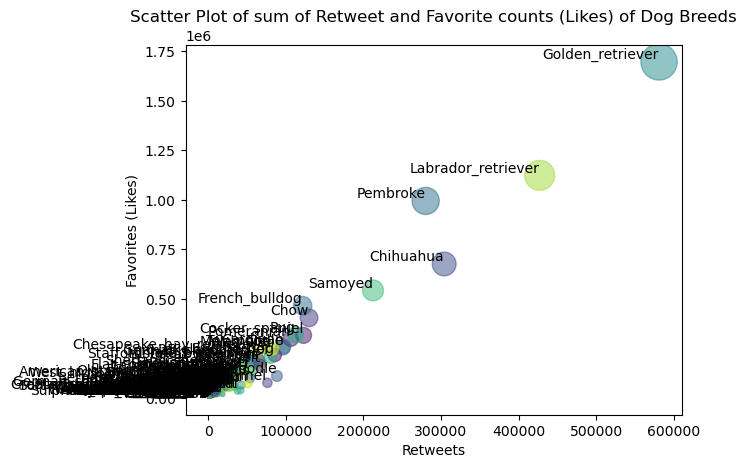

<Figure size 640x480 with 0 Axes>

In [16]:
#plotting the queried dataset
labeled_scatter(df_q1.retweet_count.values,
                df_q1.favorite_count.values,
                df_q1.index.values,
                'Retweets',
                'Favorites (Likes)',
                'Scatter Plot of sum of Retweet and Favorite counts (Likes) of Dog Breeds')
plt.savefig('fig_1.png')

The Golden Retriever is the dog with the highest retweets.

<a id = 'eda2'></a>
### 2. Which dog names are the top 10 most common?

In [17]:
#aggregate the dog names by value counts
dog_names_freq = df.name.value_counts()
top_10 = dog_names_freq.sort_values(ascending= False)[:10]

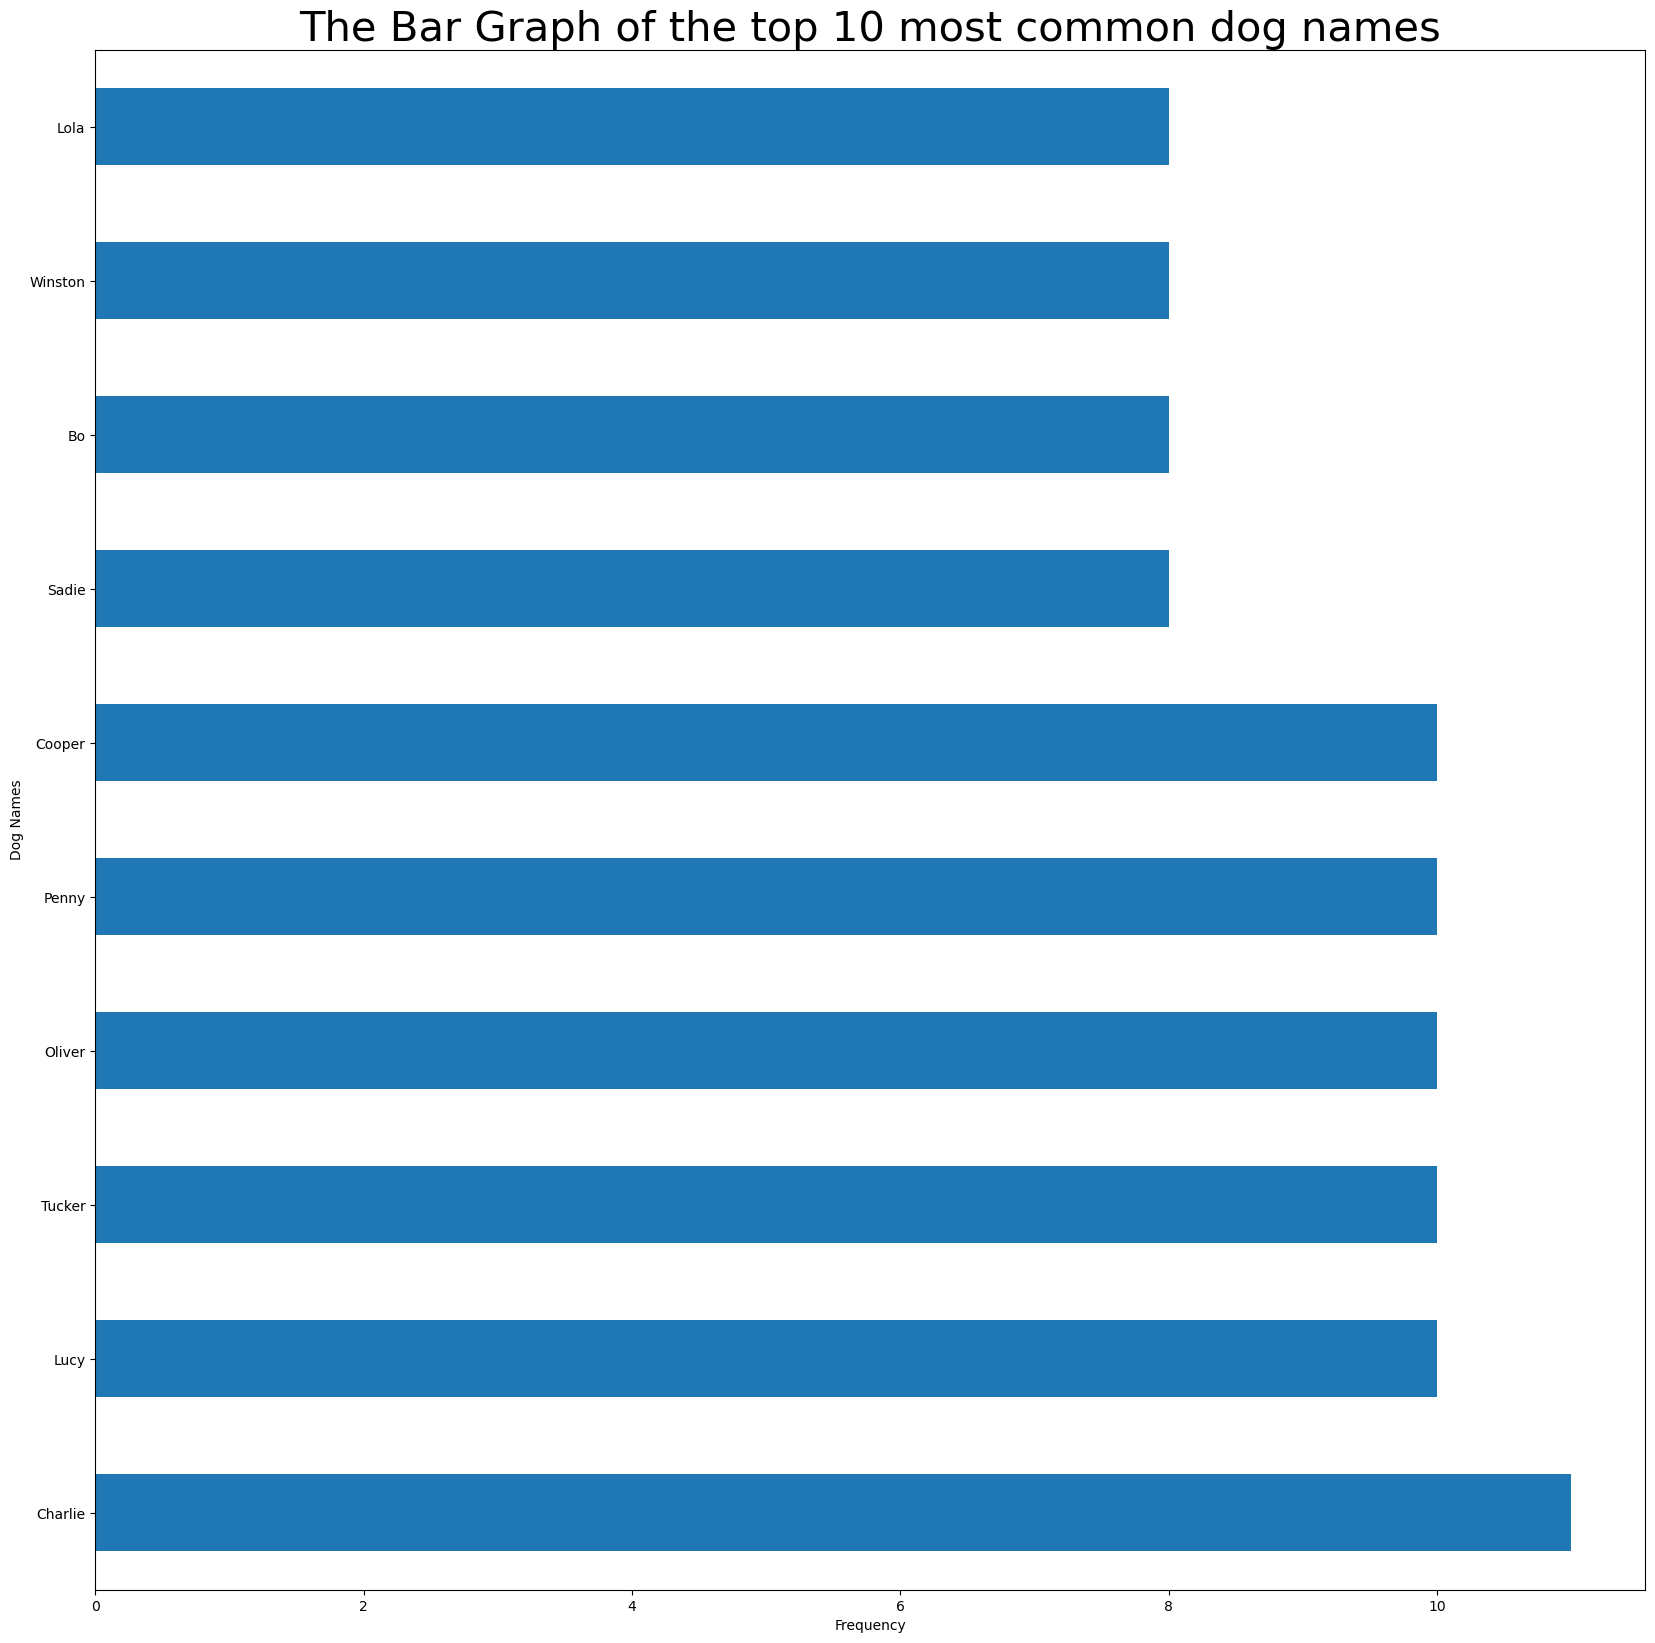

In [18]:
top_10.plot(kind = 'barh', figsize = figsize)
plt.ylabel('Dog Names')
plt.xlabel('Frequency')
plt.title('The Bar Graph of the top 10 most common dog names',fontdict={
    'fontsize':30
})
plt.savefig("fig_2.png")

<a id='eda3'></a>

### 3.  Did likes and retweets from #WeRateDogs decrease or increase overtime?

In [19]:
# Calculate the change in retweet and favorite counts over the years

#group data by the sum of their retweet_count and favorite_count by month
df_month_grp = df.groupby(pd.Grouper(key='timestamp',axis=0,freq='M'))[['retweet_count','favorite_count']].sum()

In [20]:
#Calculate the percentage change in retweet_count and favorite_count
shifted_df_month_grp = df_month_grp.shift(1).fillna(0)

#Calculate percentage change in retweet_count 
df_month_grp['percent_chg_retweet_count'] = ((df_month_grp.retweet_count - shifted_df_month_grp.retweet_count)/df_month_grp.retweet_count)*100

#Calculate percentage change in favorite_count
df_month_grp['percent_chg_favorite_count']= ((df_month_grp.favorite_count - shifted_df_month_grp.favorite_count)/df_month_grp.favorite_count)*100

In [21]:
df_month_grp

,retweet_count,favorite_count,percent_chg_retweet_count,percent_chg_favorite_count
timestamp,,,,
2015-11-30,160130.0,366498.0,100.000000,100.000000
2015-12-31,557795.0,1290510.0,71.292321,71.600530
2016-01-31,254018.0,668534.0,-119.588769,-93.035807
2016-02-29,176525.0,473156.0,-43.899164,-41.292512
2016-03-31,196768.0,554068.0,10.287750,14.603262
2016-04-30,87113.0,254008.0,-125.876735,-118.130138
2016-05-31,122696.0,343518.0,29.000945,26.056859
2016-06-30,329094.0,761103.0,62.717035,54.865767
2016-07-31,281933.0,614307.0,-16.727733,-23.896195


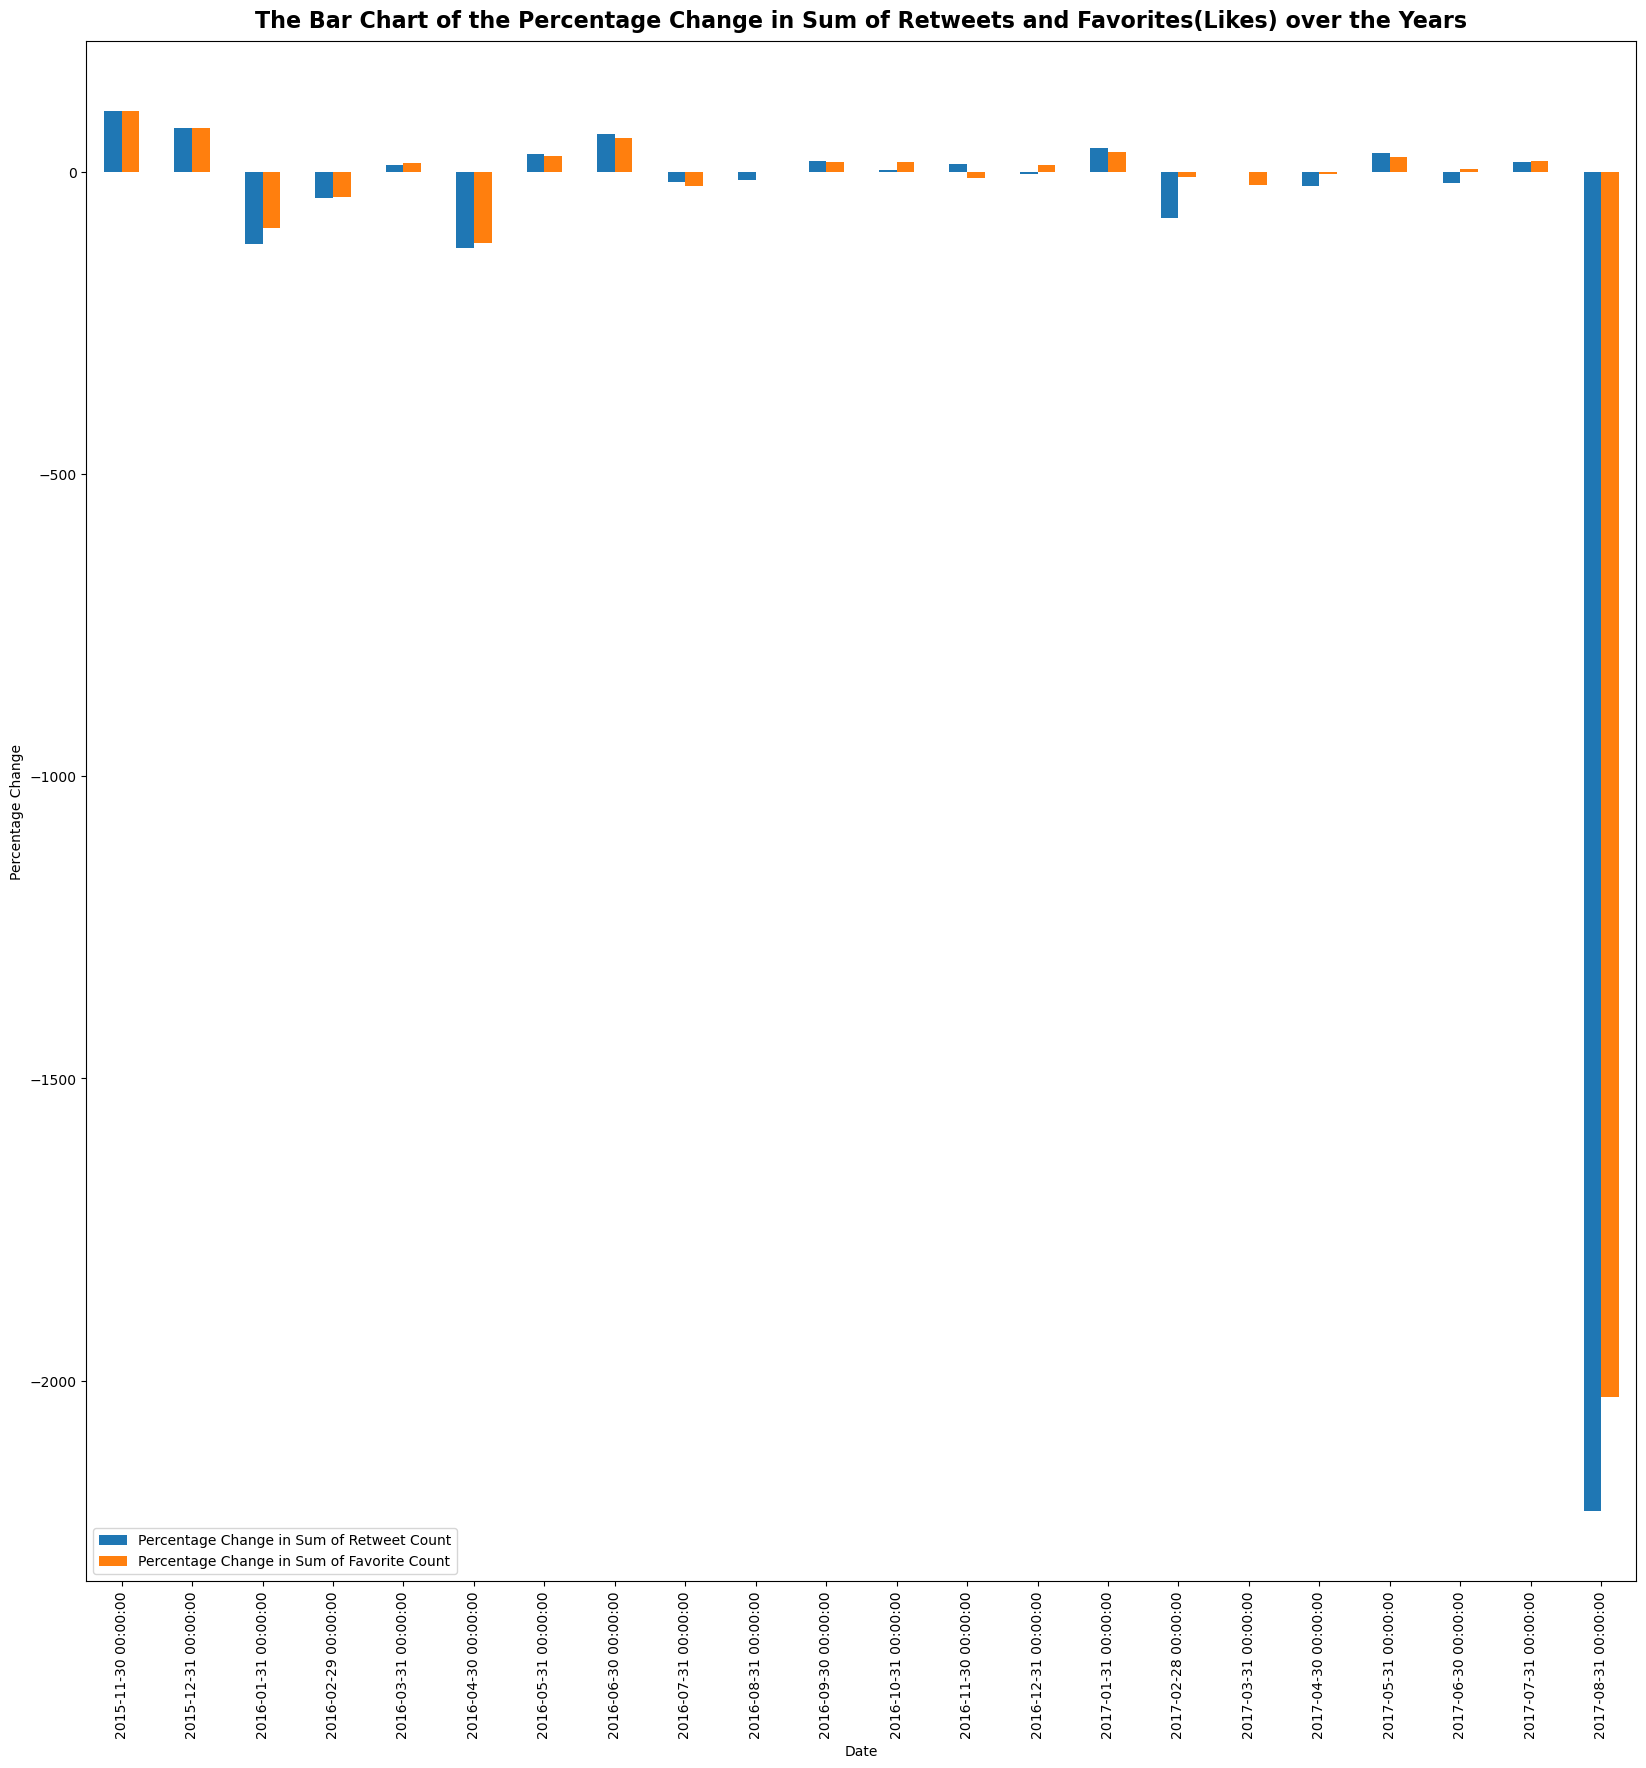

In [22]:
#plotting the bar graph of percentage change in retweet and favorite count over the months
df_month_grp[['percent_chg_retweet_count','percent_chg_favorite_count']].plot(kind='bar', figsize = figsize);
plt.title('The Bar Chart of the Percentage Change in Sum of Retweets and Favorites(Likes) over the Years',pad = 10,fontdict= {
    'fontsize':16,
    'fontweight':'bold'
})
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.legend(['Percentage Change in Sum of Retweet Count', 'Percentage Change in Sum of Favorite Count'],loc = 'lower left')
plt.savefig('fig_3.png')

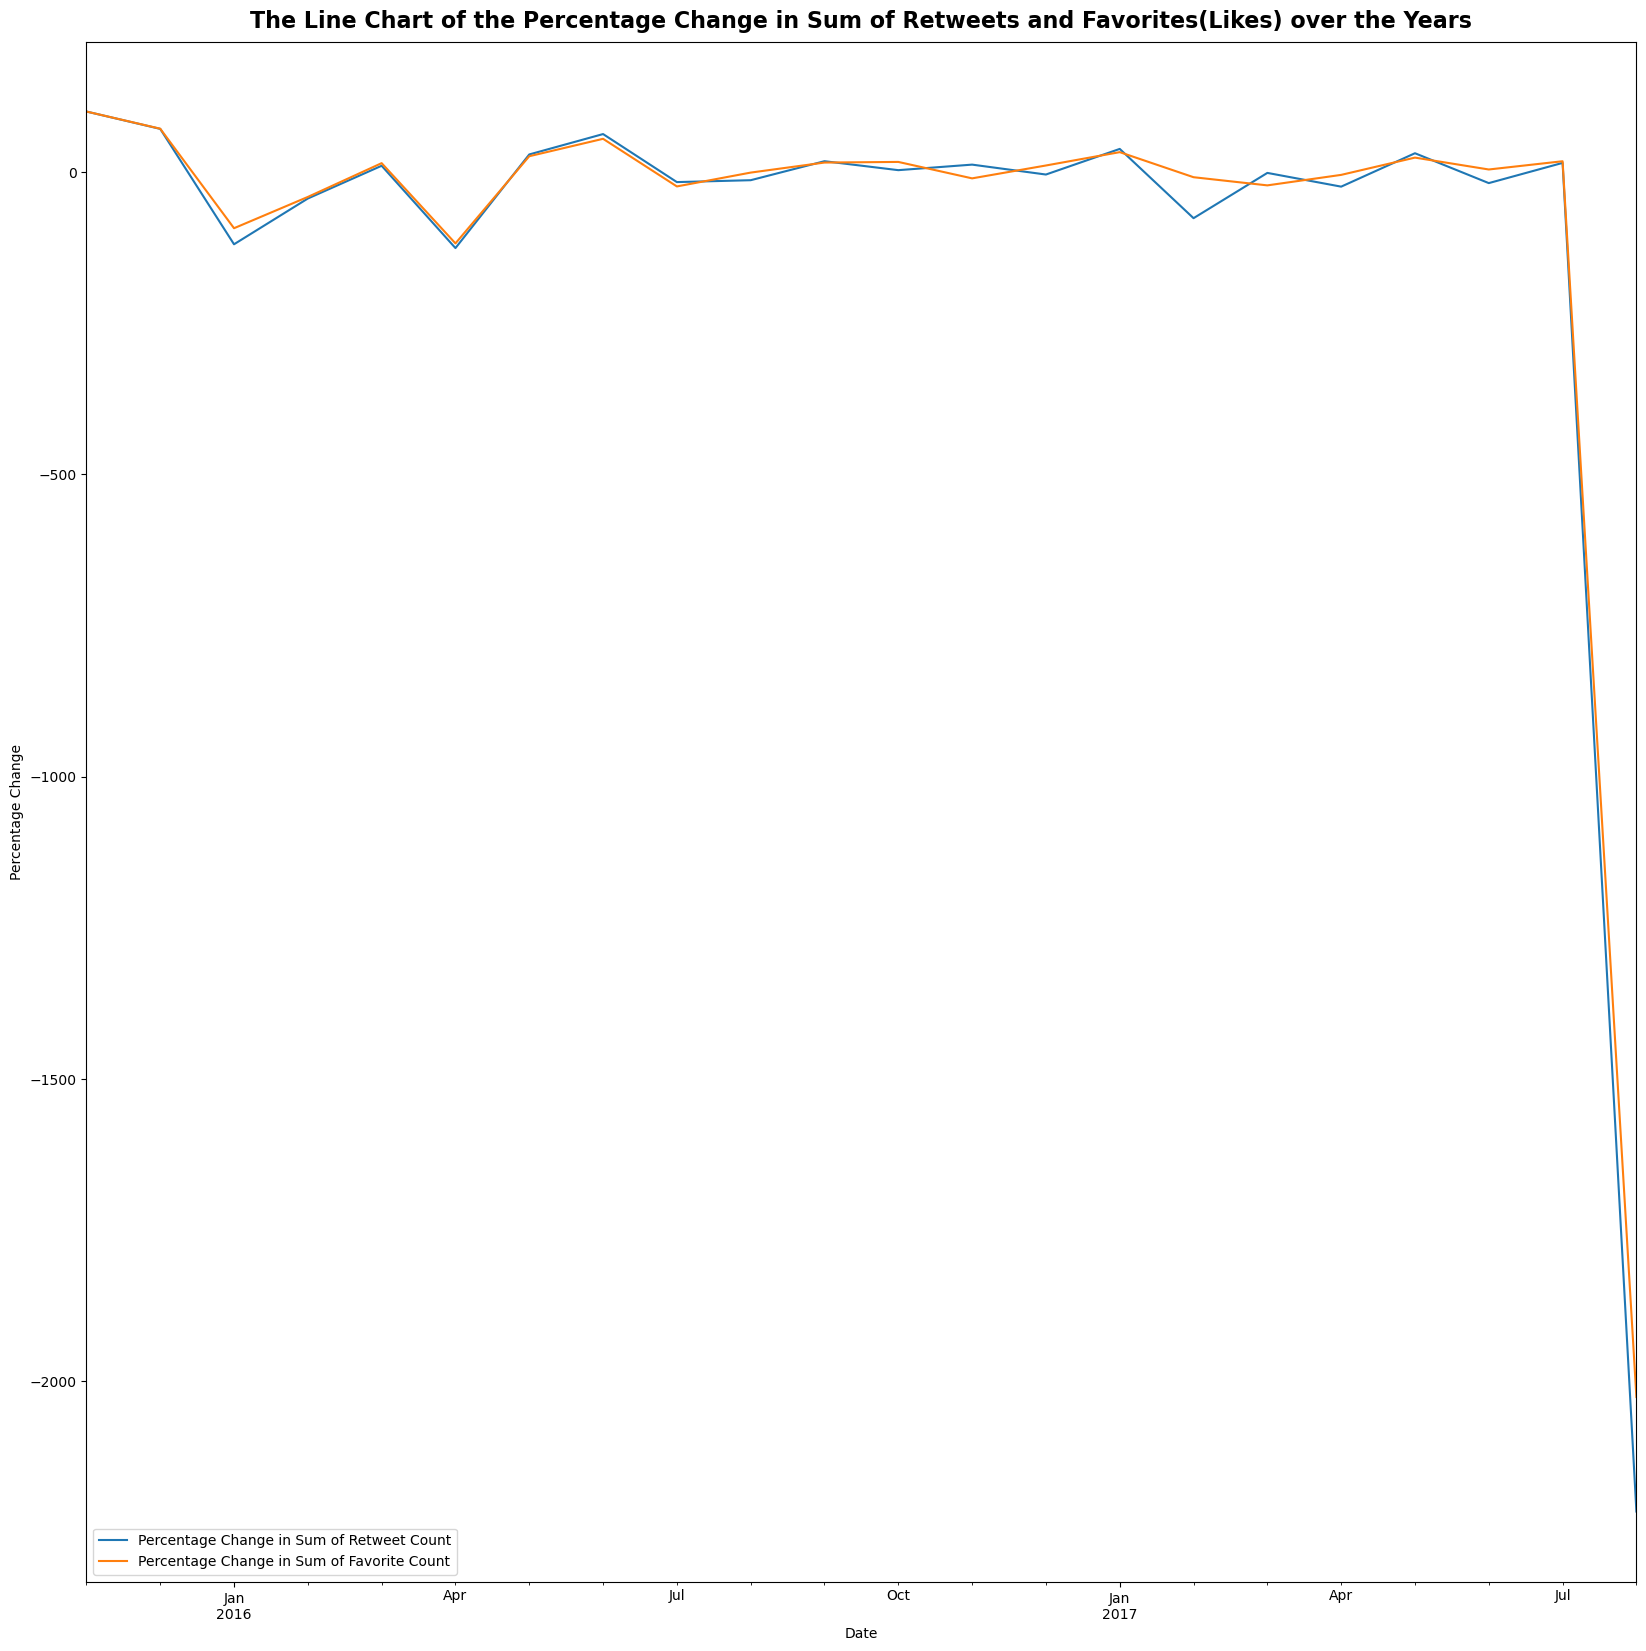

In [23]:
#plotting the line graph of percentage change in retweet and favorite count over the months
df_month_grp[['percent_chg_retweet_count','percent_chg_favorite_count']].plot(kind='line', figsize = figsize);
plt.title('The Line Chart of the Percentage Change in Sum of Retweets and Favorites(Likes) over the Years',pad = 10,fontdict= {
    'fontsize':16,
    'fontweight':'bold'
})
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.legend(['Percentage Change in Sum of Retweet Count', 'Percentage Change in Sum of Favorite Count'],loc = 'lower left')
plt.savefig('fig_4.png')

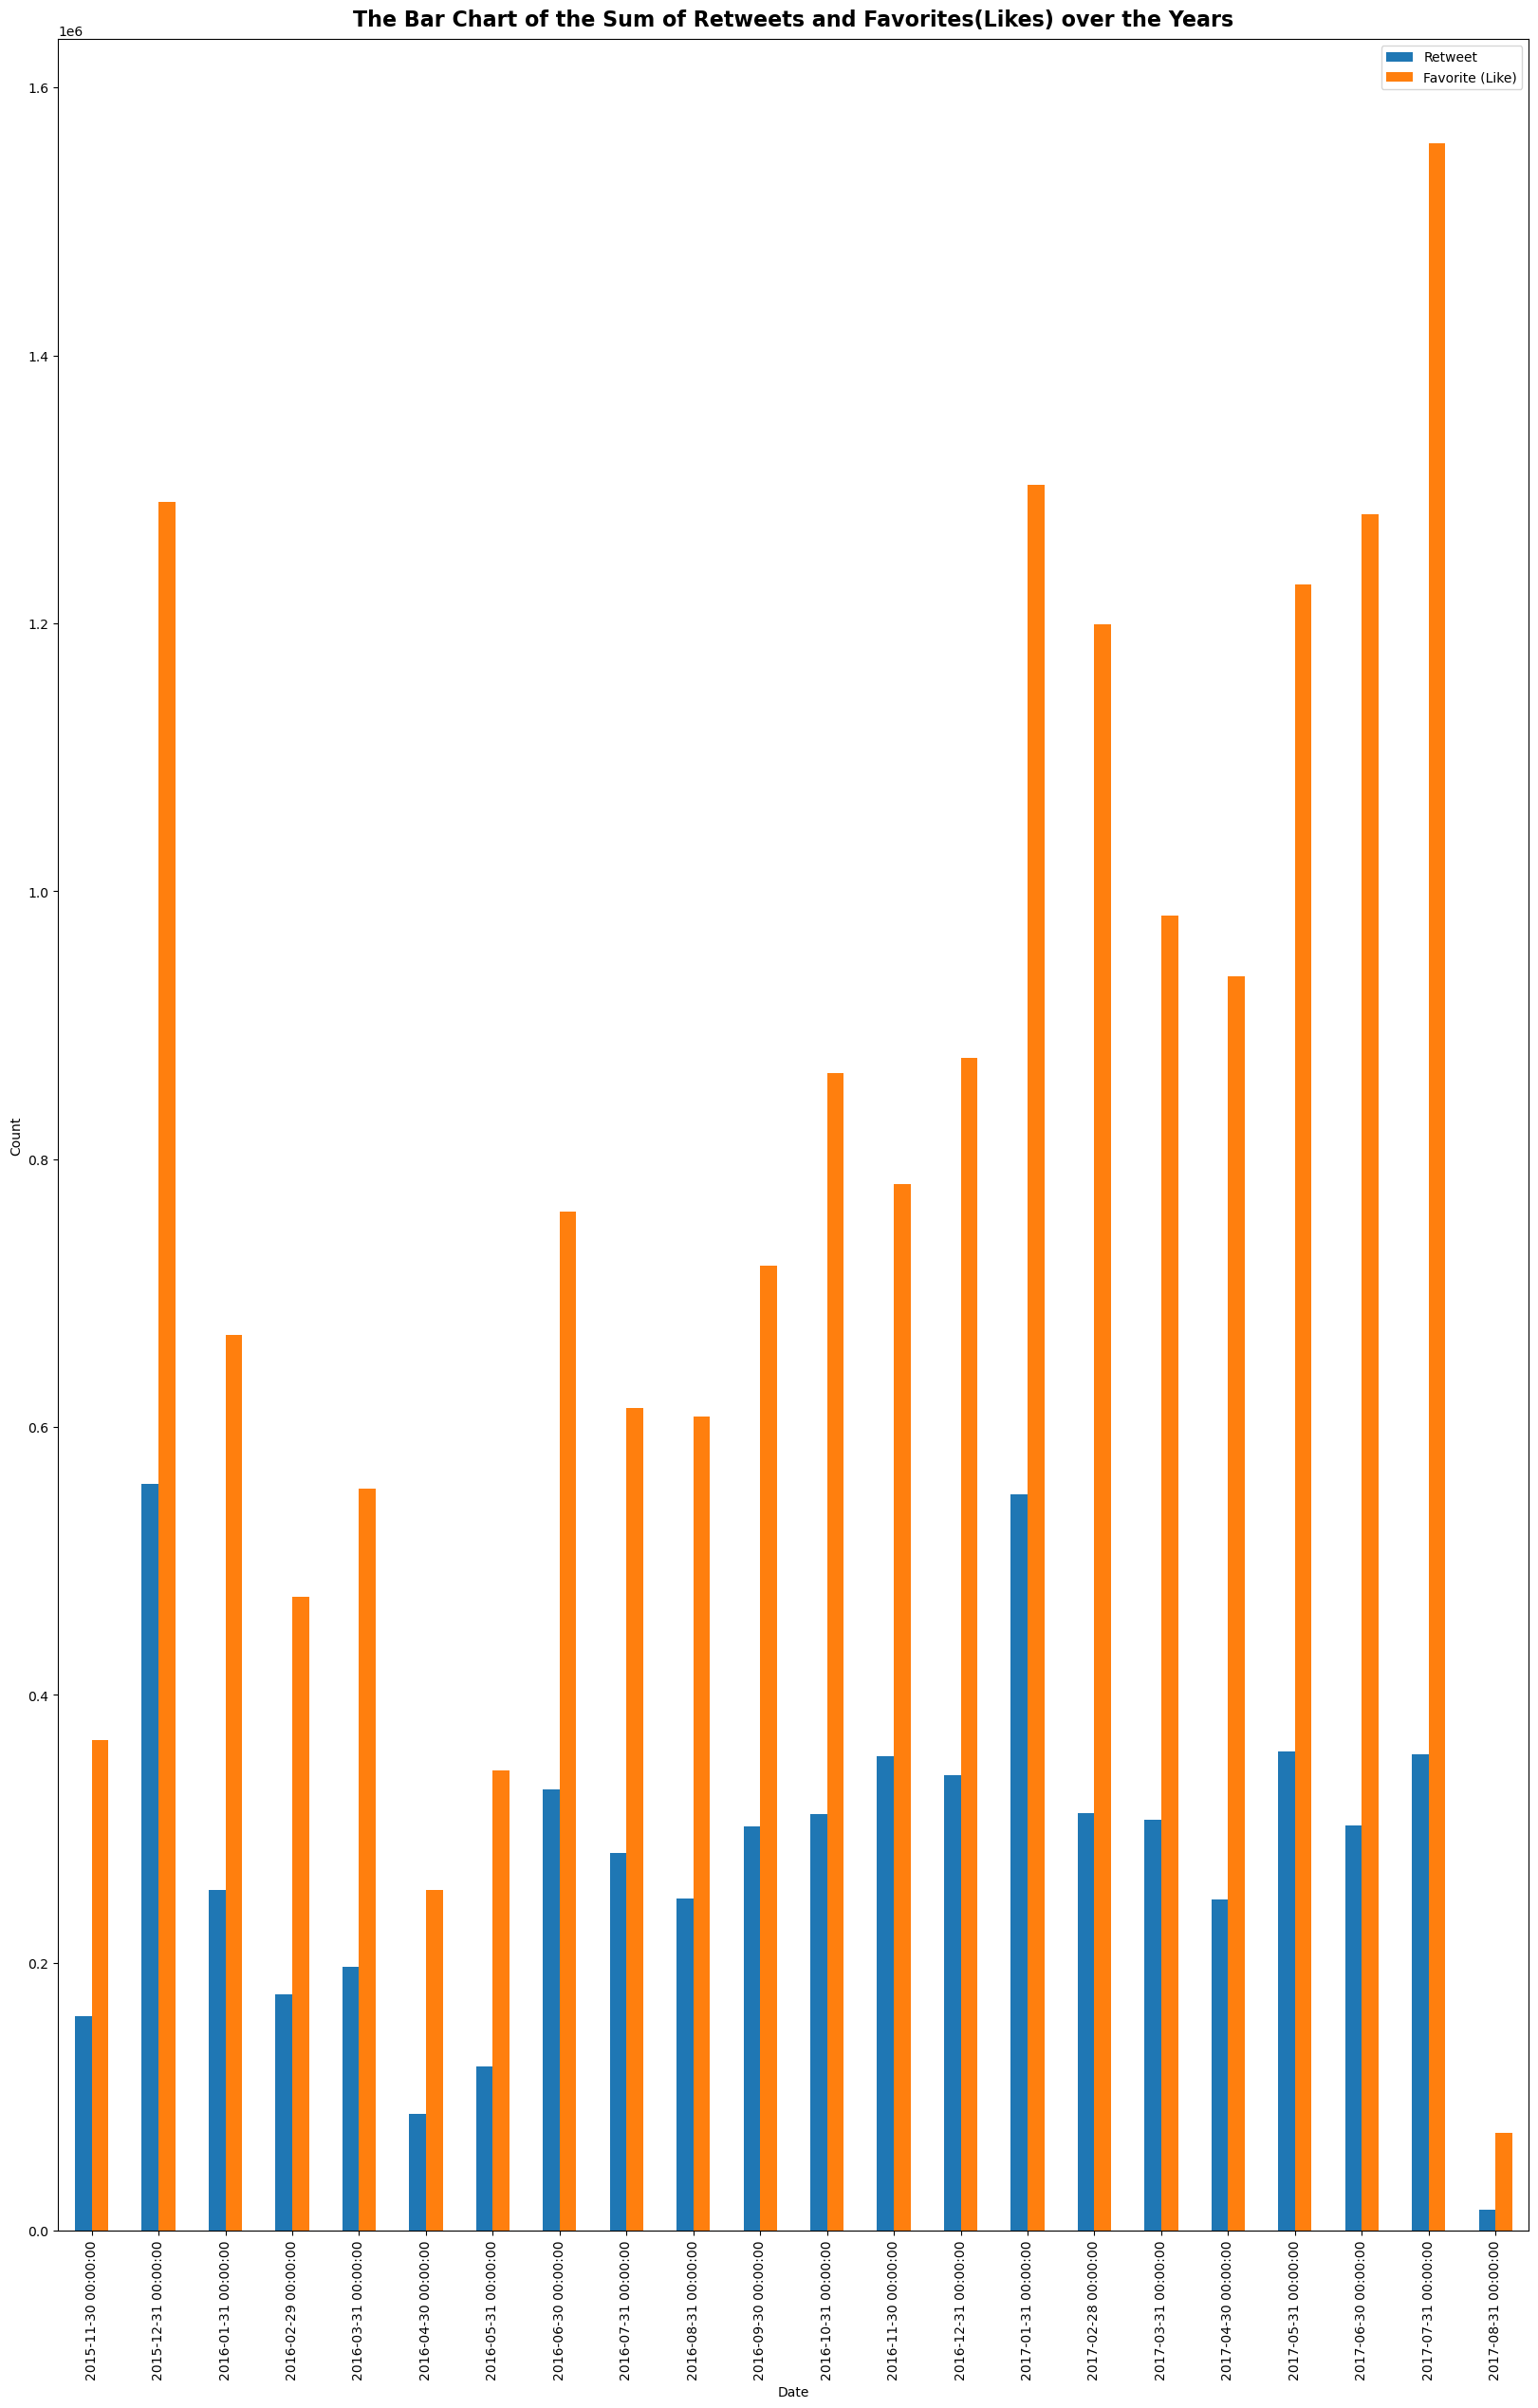

In [24]:
#plotting the bar chart of the sum of retweet and favorite counts over years
df_month_grp[['retweet_count','favorite_count']].plot(kind='bar',figsize = (20,30))
plt.title('The Bar Chart of the Sum of Retweets and Favorites(Likes) over the Years',pad = 10,fontdict= {
    'fontsize':16,
    'fontweight':'bold'
})
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(['Retweet','Favorite (Like)']);
plt.savefig('fig_5.png')

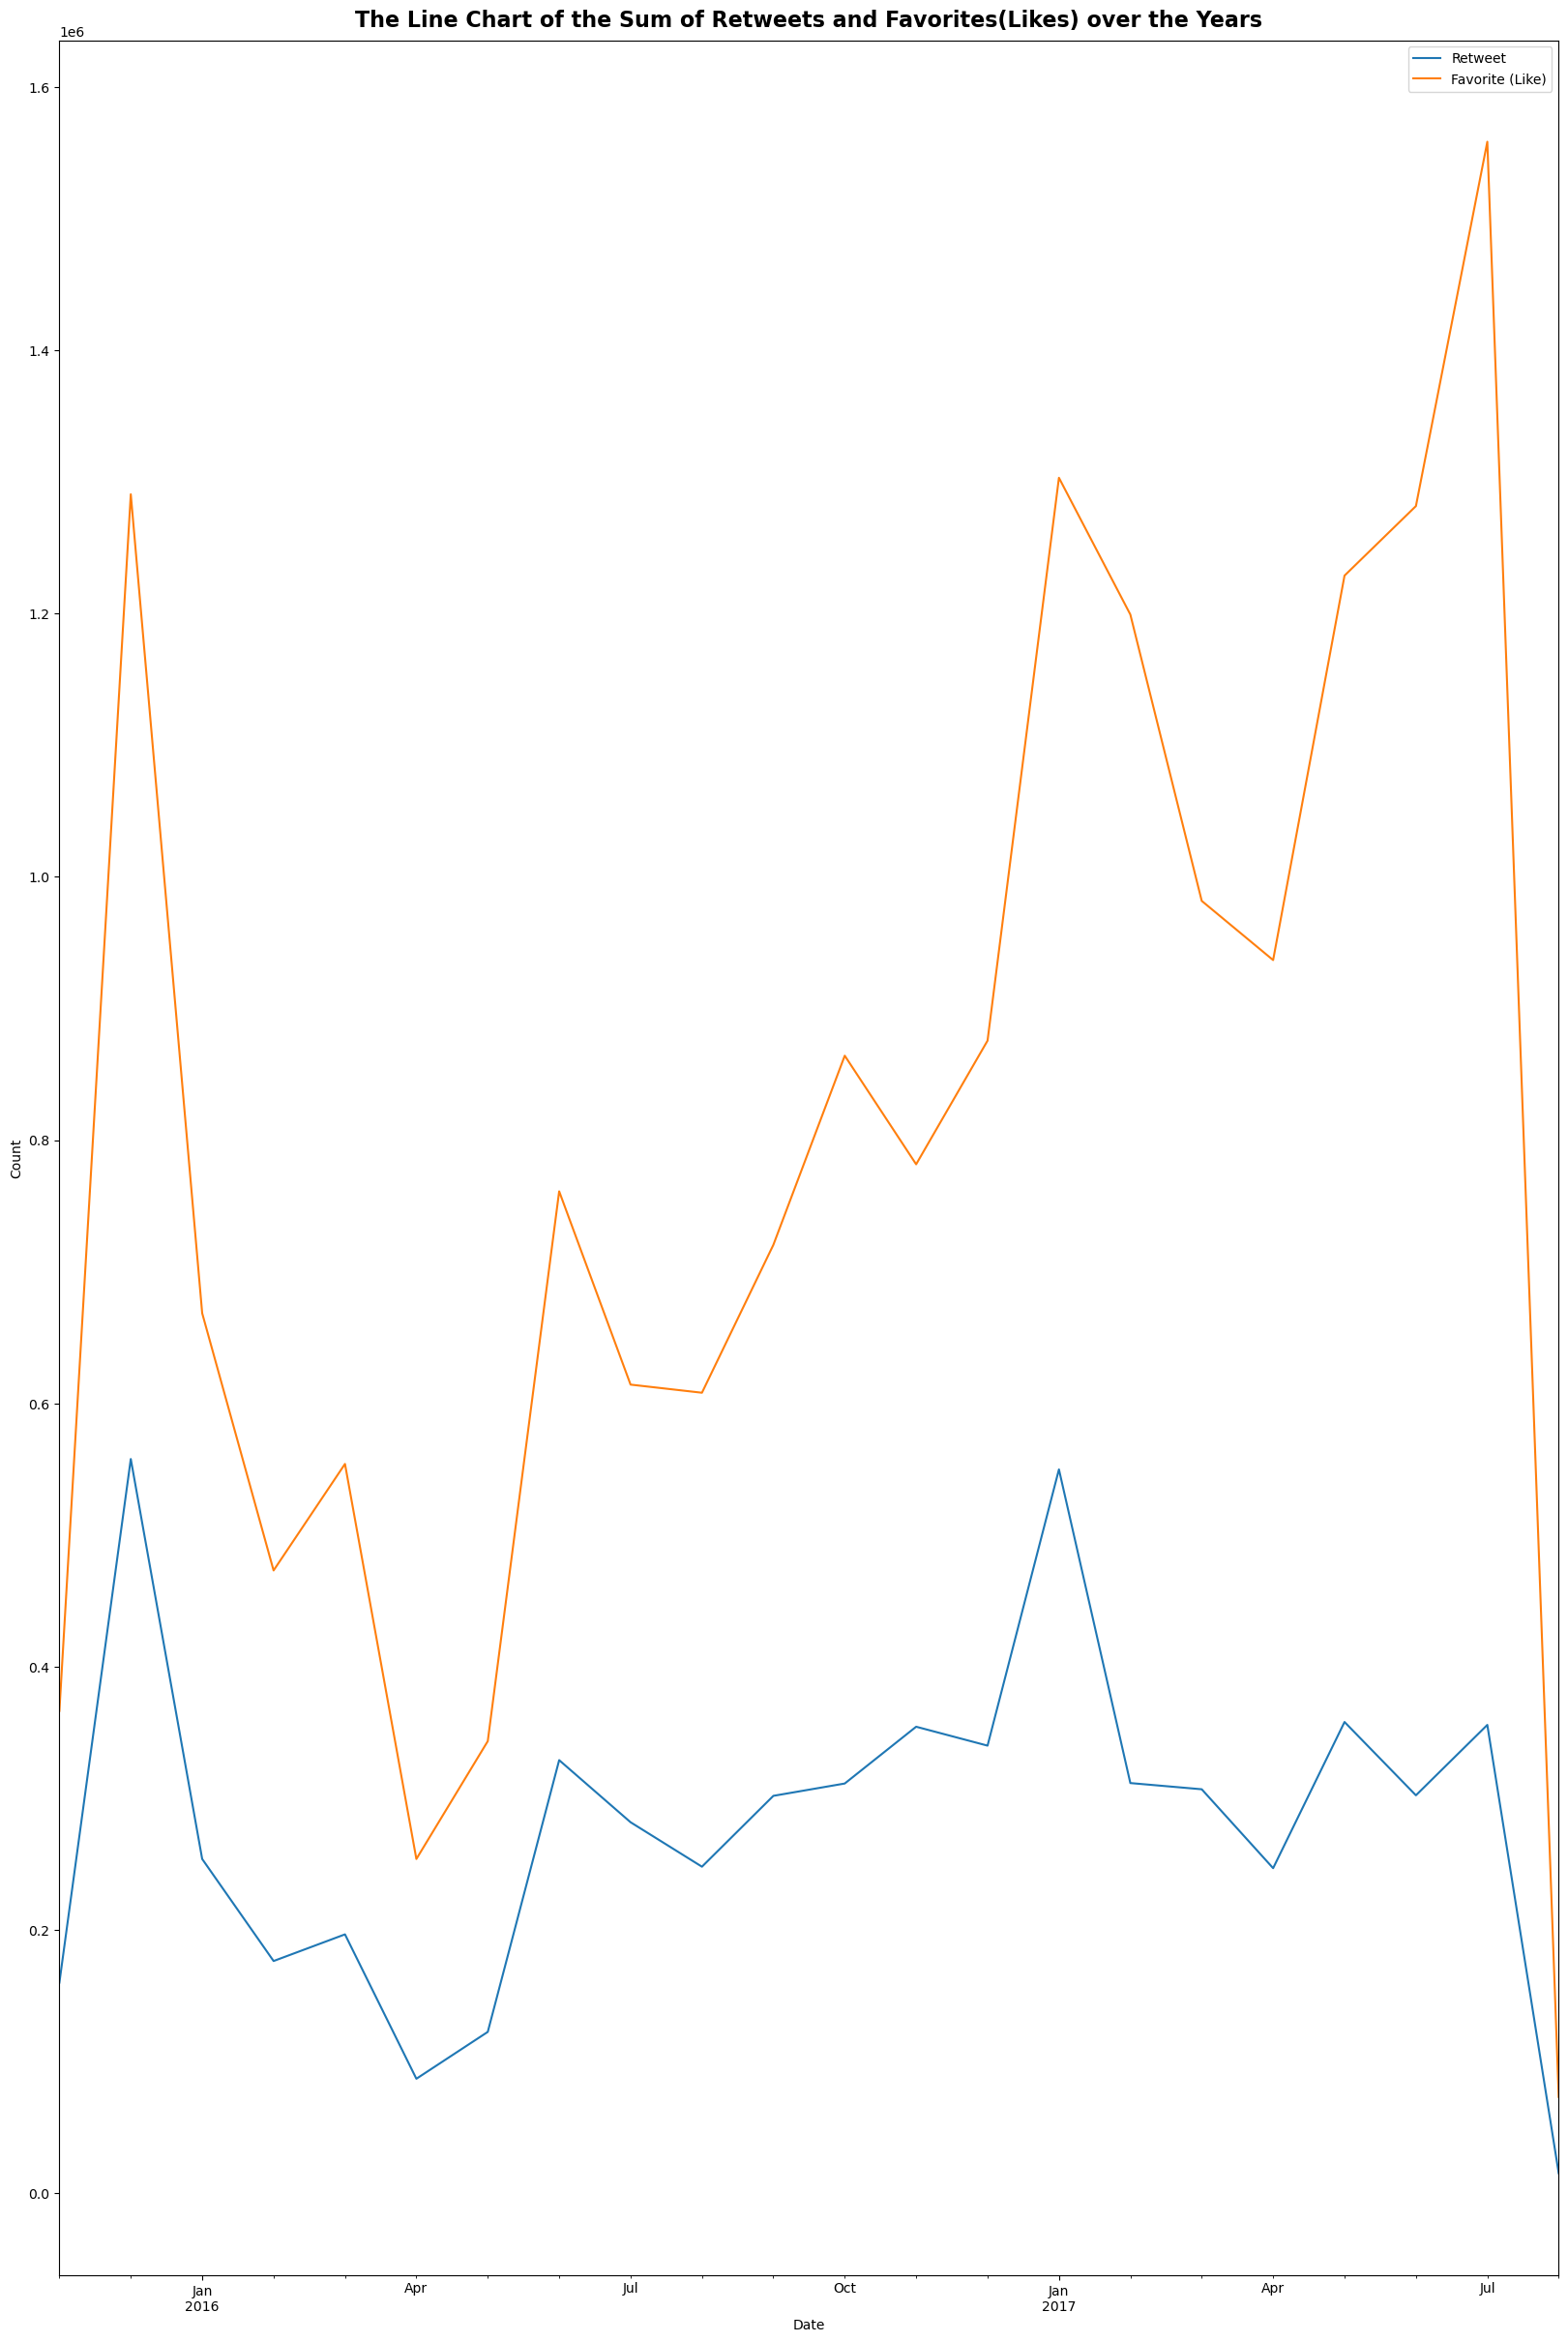

In [25]:
df_month_grp[['retweet_count','favorite_count']].plot(figsize = (20,30))
plt.title('The Line Chart of the Sum of Retweets and Favorites(Likes) over the Years',pad = 10,fontdict= {
    'fontsize':16,
    'fontweight':'bold'
})
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(['Retweet','Favorite (Like)']);
plt.savefig('fig_6.png')